### Natural Language Processing Script

In [1]:
import dill
dill.load_session('databases/testing.db')

/home/sarthak/.local/lib/python3.5/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [67]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "data/Abstract_Database_2020-09-19_15_39_CLEANED"
session_folder_name = abstracts_log_name.split('/')[-1]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[-1]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 12, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]19:16:8 Initiating the NLP Engine
[INFO]19:16:8 data/Abstract_Database_2020-09-19_15_39_CLEANED.txt is being ported to dataframe
[INFO]19:16:8 data/Abstract_Database_2020-09-19_15_39_CLEANED.txt has been ported to dataframe
[INFO]19:16:8 Trimming data and preparing list of words
[["'Diversity determinants have mostly been evaluated in high diversity areas, leaving behind regions with less species diversity such as drylands. Here we aim to analyze the patterns of plant diversity in tropical drylands in the southern Central Andes, and determine the importance of water, energy, and environmental heterogeneity as diversity determinants of the arid and semi-arid adapted flora. We examined the distribution of 645 native species from lowlands to in the north-western region of Argentina (NWA) and define hotspots of diversity within each NWA ecoregion. Diversity is concentrated in regions of middle elevation with intermediate values of water and energy, at the transition between arid and 

[INFO]19:16:10 Generating bigrams
[INFO]19:16:10 Generating word bigrams
[INFO]19:16:15 Generated word bigrams
[INFO]19:16:16 Beginning lemmatization
[INFO]19:16:32 Ending lemmatization
[INFO]19:16:53 Issued perplexity: -9.78046242407654
[INFO]19:16:53 Idling the NLP Engine


Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [13]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [14]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

TypeError: unorderable types: int() < tuple()

Saving the ```dataframe``` to disc for analysis.

In [ ]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [ ]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [ ]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [ ]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [ ]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [ ]:
df_dominant_topics

Saving it to a ```.csv``` bucket here.

In [ ]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [68]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [73]:
[vis[0].iloc[topic].name for topic in range(lda_model.num_topics)]

[4, 10, 2, 7, 6, 5, 8, 1, 0, 3, 9, 11]

Enabling the visualizations in the notebook here.

In [3]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [13]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [31]:
vis[0].columns = ['']*len(vis[0].columns)

In [55]:
topic_order = []
num_topics = 12
for topic in range(num_topics):
    topic_order.append(vis[0].iloc[topic].name)

In [56]:
topic_order

[4, 10, 2, 7, 6, 5, 8, 1, 0, 3, 9, 11]

In [52]:
lda_model.num_topics

12

In [2]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      23.112831        1       1  0.256347 -0.020051
10     20.442476        1       2  0.251929  0.094092
2      16.950708        1       3  0.236244 -0.012509
7      13.641024        1       4  0.183556  0.229317
6       8.979827        1       5  0.101830 -0.154445
5       8.248853        1       6  0.063145 -0.263687
8       3.005005        1       7 -0.133485 -0.072136
1       2.875950        1       8 -0.138727  0.087783
0       1.649856        1       9 -0.193723  0.039363
3       0.549623        1      10 -0.214263  0.027348
9       0.433698        1      11 -0.210856  0.024373
11      0.110159        1      12 -0.201997  0.020552, topic_info=      Category         Freq              Term        Total  loglift  logprob
10669  Default  1511.000000            forest  1511.000000  30.0000  30.0000
10578  Default  1087.000000              soil  

In [4]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      23.112831        1       1  0.256347 -0.020051
10     20.442476        1       2  0.251929  0.094092
2      16.950708        1       3  0.236244 -0.012509
7      13.641024        1       4  0.183556  0.229317
6       8.979827        1       5  0.101830 -0.154445
5       8.248853        1       6  0.063145 -0.263687
8       3.005005        1       7 -0.133485 -0.072136
1       2.875950        1       8 -0.138727  0.087783
0       1.649856        1       9 -0.193723  0.039363
3       0.549623        1      10 -0.214263  0.027348
9       0.433698        1      11 -0.210856  0.024373
11      0.110159        1      12 -0.201997  0.020552, topic_info=      Category         Freq              Term        Total  loglift  logprob
10669  Default  1511.000000            forest  1511.000000  30.0000  30.0000
10578  Default  1087.000000              soil  1087.000000  29.0000  29.0000
860    Default  1183.000000             plant  1183.000000  28.0000  28.0000
15344  Default  1047.000000        population  1047.000000  27.0000  27.0000
3867   Default   574.000000             water   574.000000  26.0000  26.0000
15387  Default   565.000000           genetic   565.000000  25.0000  25.0000
7347   Default   315.000000              seed   315.000000  24.0000  24.0000
6832   Default   531.000000               new   531.000000  23.0000  23.0000
9106   Default   289.000000          activity   289.000000  22.0000  22.0000
3549   Default   792.000000             model   792.000000  21.0000  21.0000
2457   Default   545.000000           climate   545.000000  20.0000  20.0000
13671  Default   614.000000              tree   614.000000  19.0000  19.0000
7217   Default   586.000000            system   586.000000  18.0000  18.0000
14332  Default   952.000000            change   952.000000  17.0000  17.0000
16396  Default   231.000000             fruit   231.000000  16.0000  16.0000
1100   Default   613.000000         community   613.000000  15.0000  15.0000
8216   Default   429.000000          research   429.000000  14.0000  14.0000
8527   Default   321.000000              crop   321.000000  13.0000  13.0000
8650   Default   198.000000              root   198.000000  12.0000  12.0000
1914   Default   774.000000             group   774.000000  11.0000  11.0000
7916   Default   821.000000         diversity   821.000000  10.0000  10.0000
8792   Default   352.000000          resource   352.000000   9.0000   9.0000
13694  Default  1019.000000          increase  1019.000000   8.0000   8.0000
9377   Default   371.000000       development   371.000000   7.0000   7.0000
8056   Default   330.000000         knowledge   330.000000   6.0000   6.0000
7676   Default   685.000000      distribution   685.000000   5.0000   5.0000
70     Default   267.000000              food   267.000000   4.0000   4.0000
15912  Default   523.000000              site   523.000000   3.0000   3.0000
1177   Default   260.000000             genus   260.000000   2.0000   2.0000
1905   Default   388.000000          richness   388.000000   1.0000   1.0000
...        ...          ...               ...          ...      ...      ...
14158  Topic12     0.012765        kingfisher     0.894486   2.5615  -9.7735
6979   Topic12     0.012796         saccharum     0.896854   2.5613  -9.7711
13944  Topic12     0.012759         podzolise     0.894720   2.5607  -9.7740
3086   Topic12     0.012750     discoloration     0.894116   2.5607  -9.7747
13336  Topic12     0.012796          robustum     0.897410   2.5606  -9.7711
10126  Topic12     0.012963            romney     0.909888   2.5598  -9.7582
12684  Topic12     0.012881              lamb     0.904468   2.5594  -9.7645
10857  Topic12     0.012881           suffolk     0.904468   2.5594  -9.7645
1318   Topic12     0.012843        millennial     0.901368   2.5599  -9.7674
6915   Topic12     0.012906              itc

In [15]:
lda_model

In [16]:
optimal_model = lda_model

In [24]:
from matplotlib import cm
cols = cm.get_cmap('plasma', 10)

In [15]:
lda_model.show_topics(num_topics = -1, num_words = 30)

[(0,
  '0.028*"fire" + 0.025*"activity" + 0.025*"deforestation" + 0.017*"hybrid" + 0.015*"bank" + 0.013*"pine" + 0.011*"income" + 0.011*"developing_countrie" + 0.010*"vertical" + 0.009*"park" + 0.009*"institution" + 0.009*"lulc" + 0.009*"manage" + 0.009*"shoot" + 0.009*"land_cover" + 0.008*"government" + 0.008*"best" + 0.008*"last" + 0.008*"financial" + 0.008*"interval" + 0.007*"considerably" + 0.007*"nature" + 0.007*"gas" + 0.007*"accuracy" + 0.007*"shell" + 0.007*"typically" + 0.007*"actual" + 0.006*"grassland" + 0.006*"burn" + 0.006*"manager"'),
 (1,
  '0.143*"forest" + 0.016*"formation" + 0.014*"fragment" + 0.014*"respectively" + 0.013*"distance" + 0.012*"statistical" + 0.011*"primate" + 0.010*"correlation" + 0.010*"seedling" + 0.010*"typical" + 0.010*"recruitment" + 0.010*"fragmentation" + 0.010*"colonization" + 0.009*"largely" + 0.009*"coefficient" + 0.008*"invasion" + 0.008*"minimum" + 0.008*"threshold" + 0.008*"plasmodium" + 0.008*"regeneration" + 0.007*"mortality" + 0.007*"pla

In [16]:
for topic in topics:
    sum = 0
    for element in (topic[1].split('+')):
        sum = sum + float(element.split('*')[0])
    print(sum)

0.31600000000000017
0.4110000000000002
0.2120000000000001
0.31500000000000017
0.1840000000000001
0.28700000000000014
0.25500000000000006
0.2710000000000001
0.3870000000000002
0.27800000000000014
0.25800000000000006
0.013


In [59]:
def topic_builder(optimal_model, session_folder_name, textual_data_lemmatized, topic_order):
    cols = cm.get_cmap('viridis', 12)
    topics = optimal_model.show_topics(num_topics = -1, num_words = 20, formatted=False)
    data_flat = [w for w_list in textual_data_lemmatized for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    for topic in topic_order:
        fig, ax = plt.subplots(1,1, figsize=[20, 15])
        x_axis = [x_axis_element for x_axis_element in range(0, 20)]
        x_axis_labels = [element for element in df.loc[df.topic_id==topic, 'word']]
        y_axis = [round(element, 2) for element in df.loc[df.topic_id==topic, 'word_count']]
        #y_axis_labels = [num for num in range(0, max(df.loc[df.topic_id==topic, 'word_count'])) if (num%50)==0]

        word_count_list = [word_count for word_count in df.loc[df.topic_id==topic, 'word_count']]
        word_count_increment = (max(word_count_list)/10)
        y_axis_labels = [0+ increment*(word_count_increment) for increment in range(0, 10)]
        
        #y_axis_twin_labels = np.around(np.arange(0, max(df.loc[df.topic_id==topic, 'importance']), (max(df.loc[df.topic_id==topic, 'importance']))/len(y_axis_labels), dtype=np.float32), decimals = 4)

        word_importance_list = [word_count for word_count in df.loc[df.topic_id==topic, 'importance']]
        word_importance_increment = (max(word_importance_list)/10)
        y_axis_twin_labels = [0+ increment*(word_importance_increment) for increment in range(0, 10)]

        plt.xticks(x_axis, x_axis_labels, rotation=40, horizontalalignment='right', fontsize = 25)
        ax.bar(x_axis, y_axis, width=0.5, alpha=0.3, color=cols.colors[topic], label="Word Count")
        ax.set_yticks(y_axis_labels)
        ax.tick_params(axis = 'y', labelsize = 25)
        ax.set_ylabel('Word Count', color=cols.colors[topic], fontsize = 25)
        ax.legend(loc='upper left', fontsize = 20)
        ax_twin = ax.twinx()
        ax_twin.bar(x_axis, df.loc[df.topic_id==topic, 'importance'], color=cols.colors[topic], width=0.2, label = "Weight")
        ax_twin.set_ylabel('Weight', color=cols.colors[topic], fontsize = 25)
        ax_twin.set_yticks(y_axis_twin_labels)
        ax_twin.tick_params(axis='y', labelsize = 25)
        ax_twin.legend(loc='upper right', fontsize = 20)
        plt.title('Topic Number: '+str(topic_order.index(topic) + 1), color=cols.colors[topic], fontsize=25)
        plt.savefig(session_folder_name + '/TopicNumber_' + str(topic_order.index(topic) + 1) + '.png')
        plt.show()

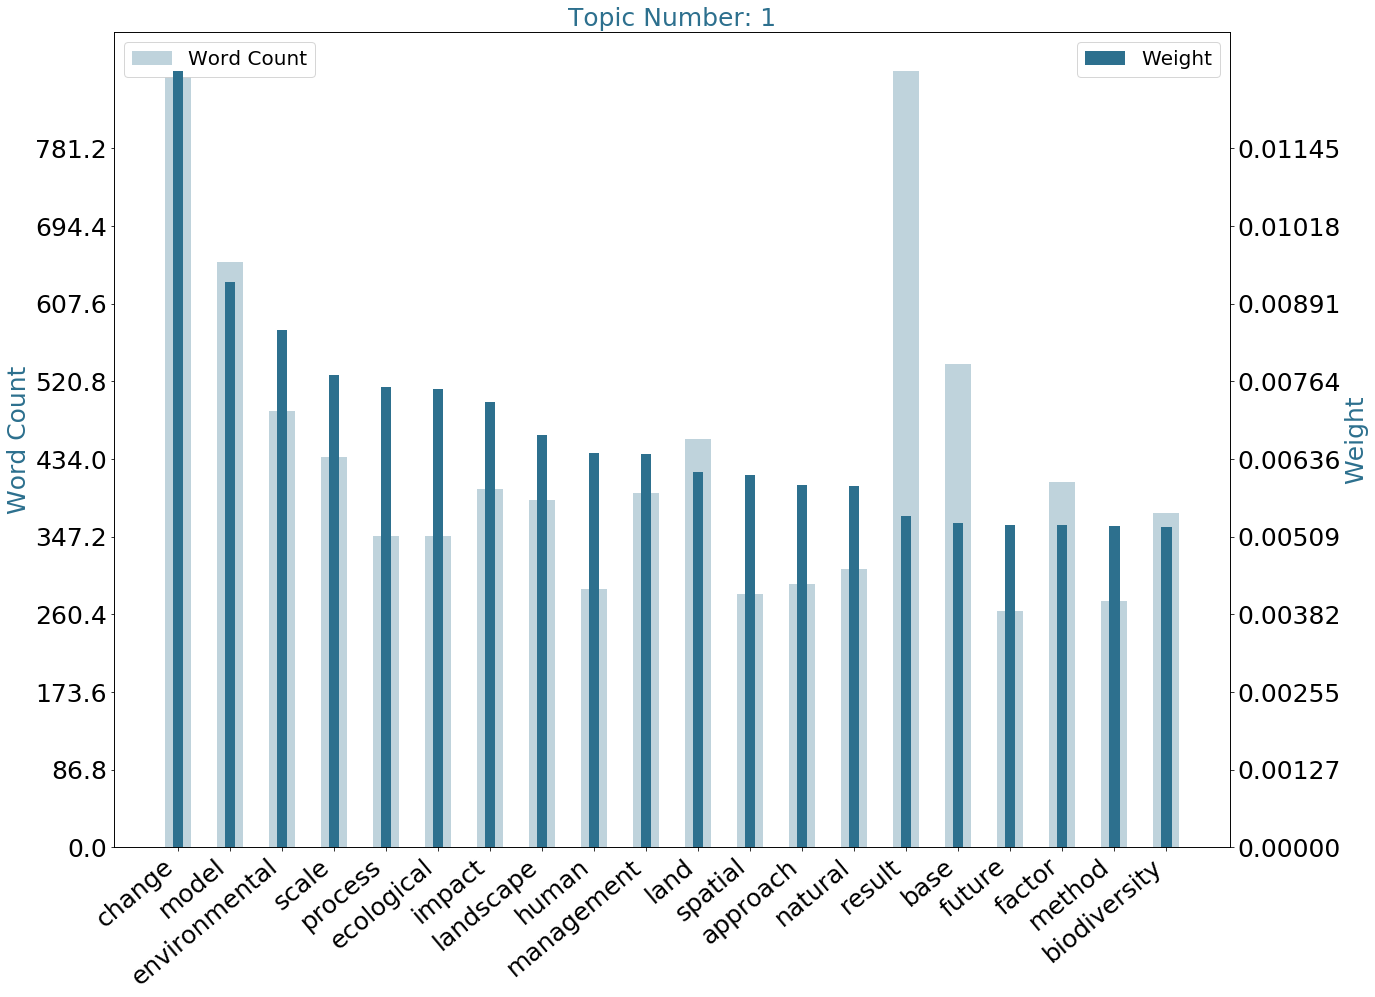

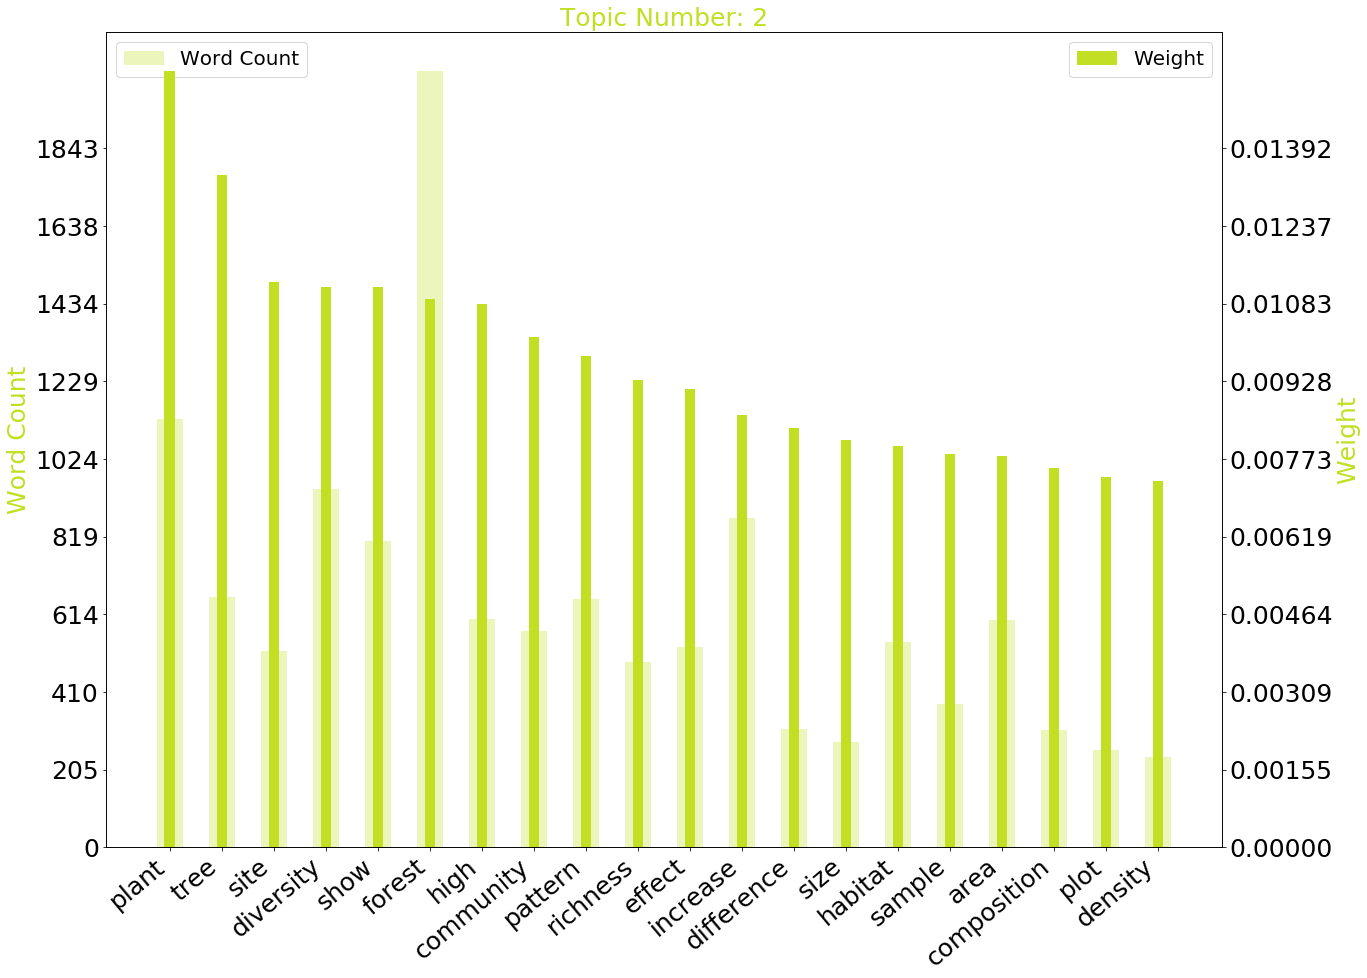

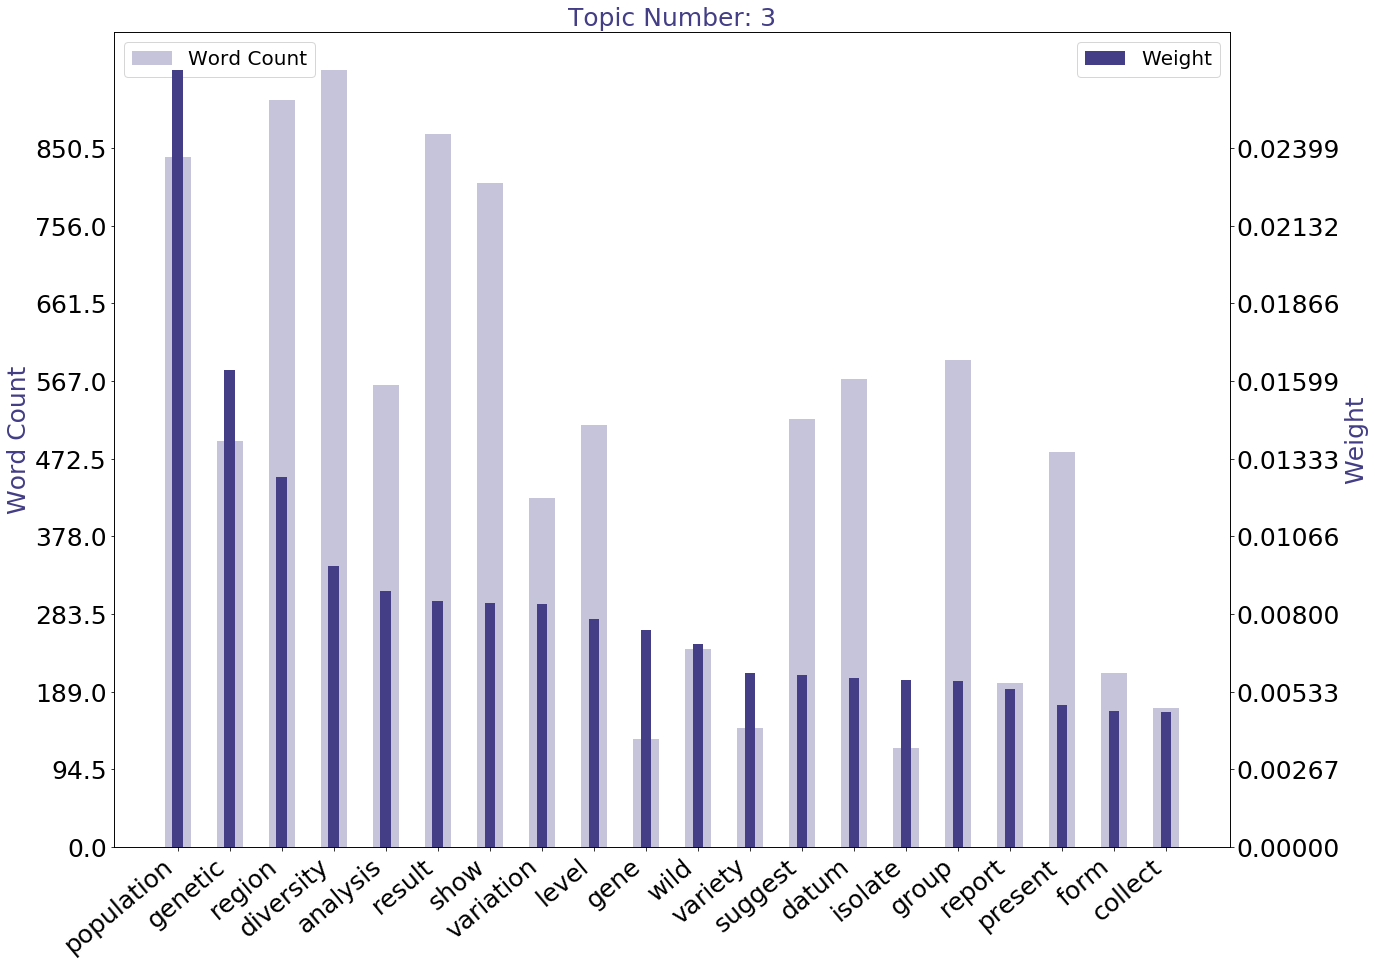

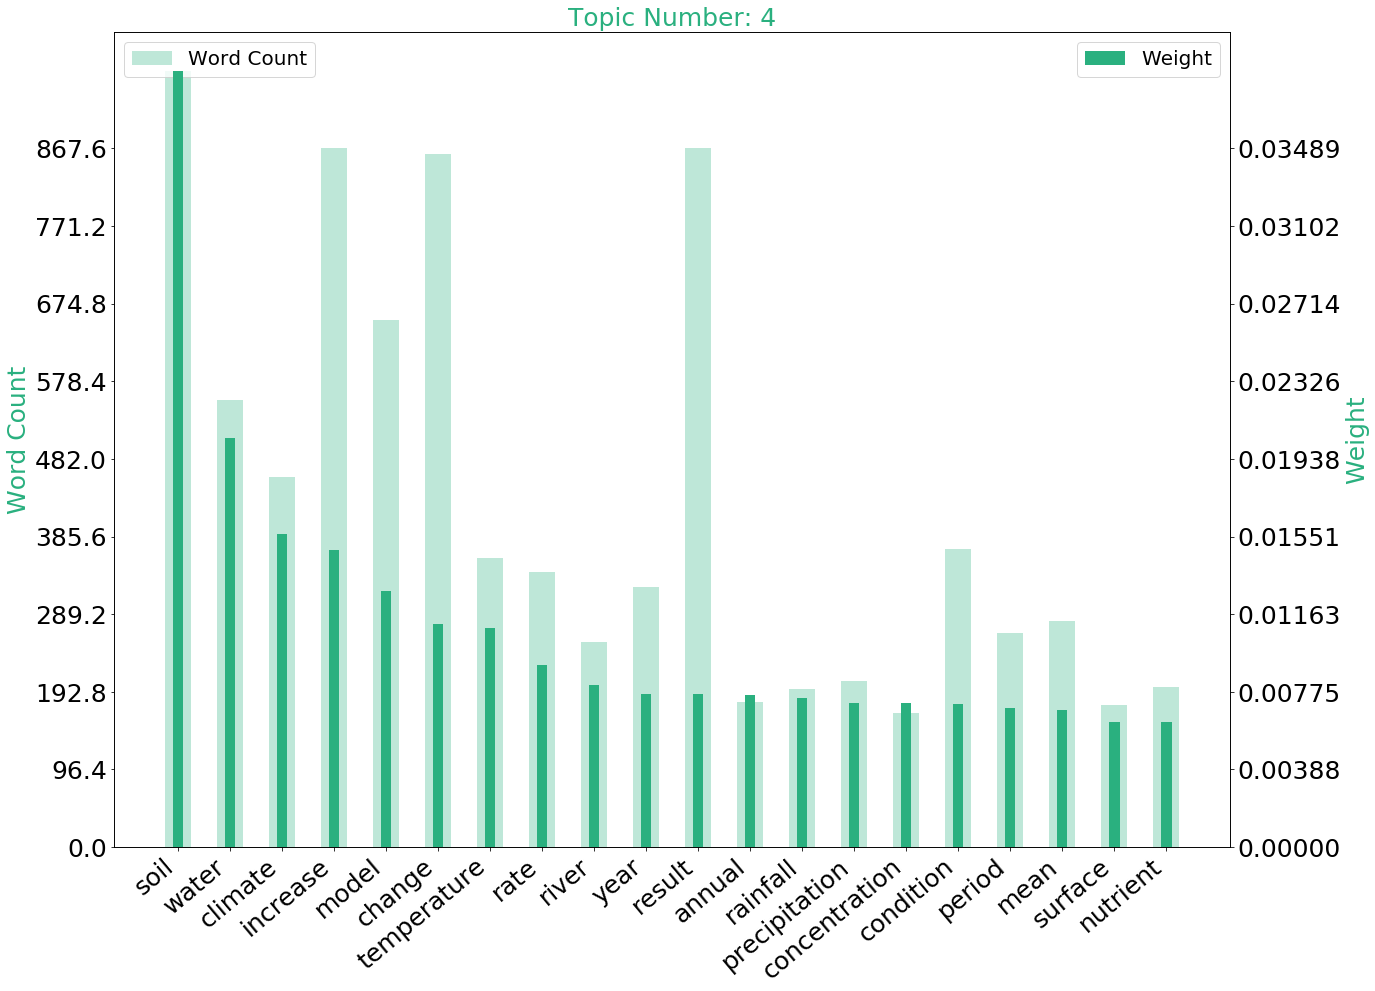

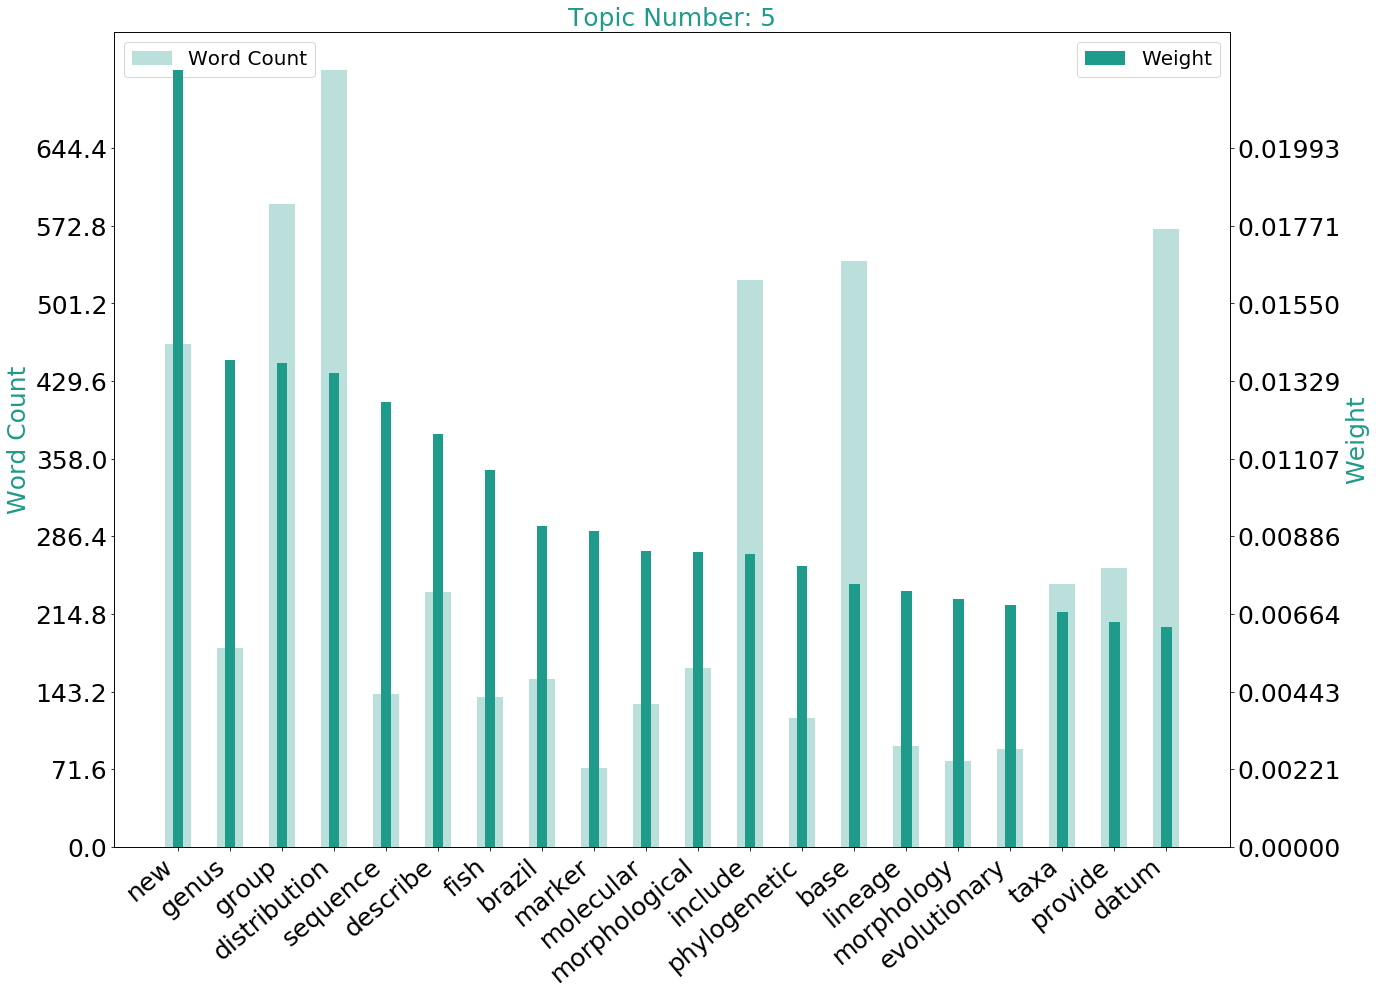

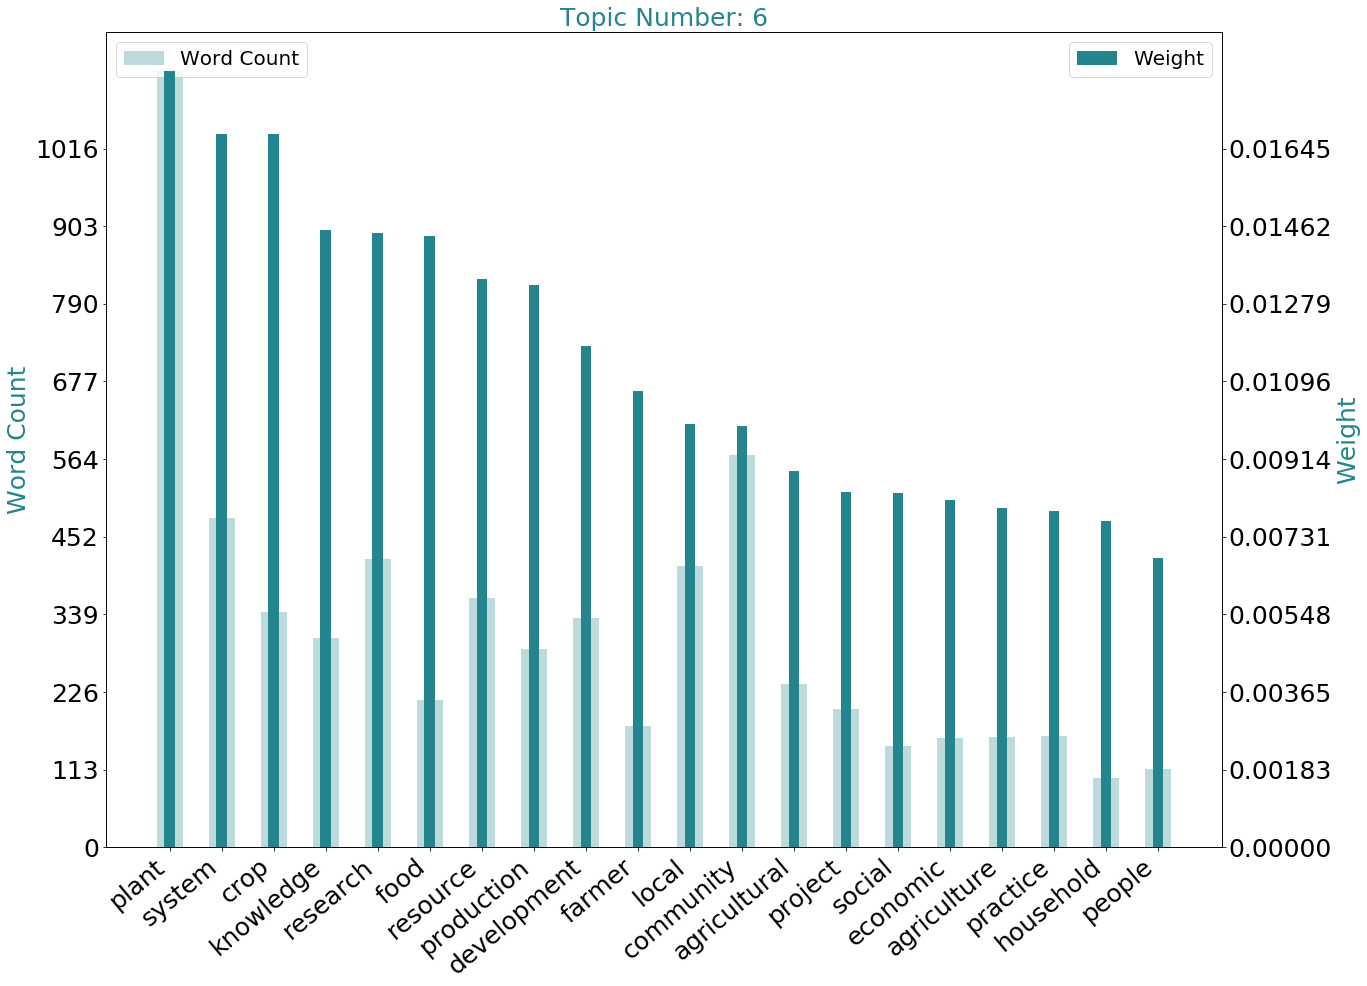

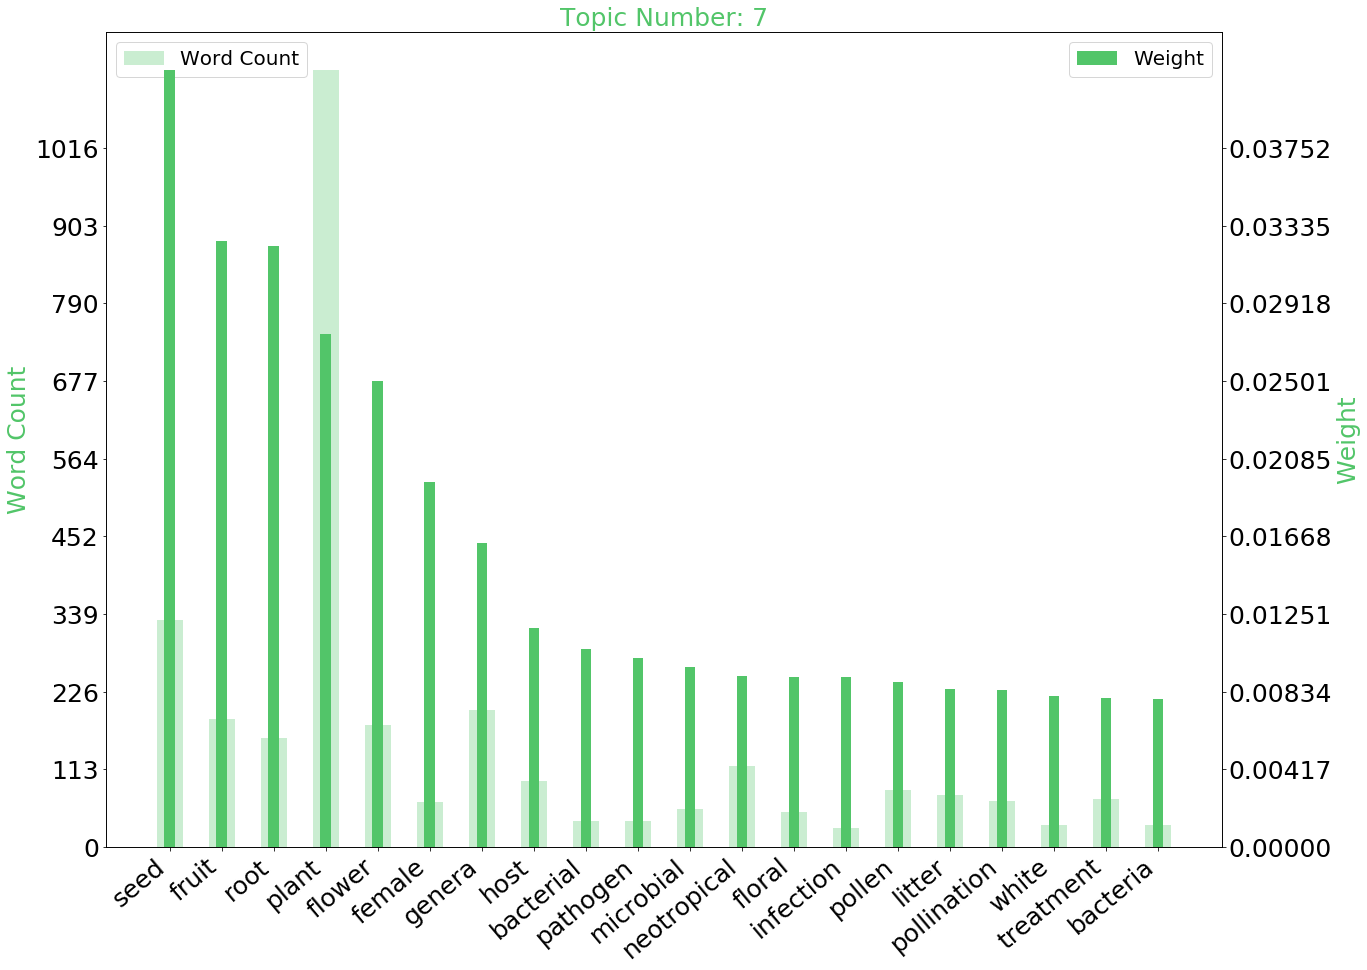

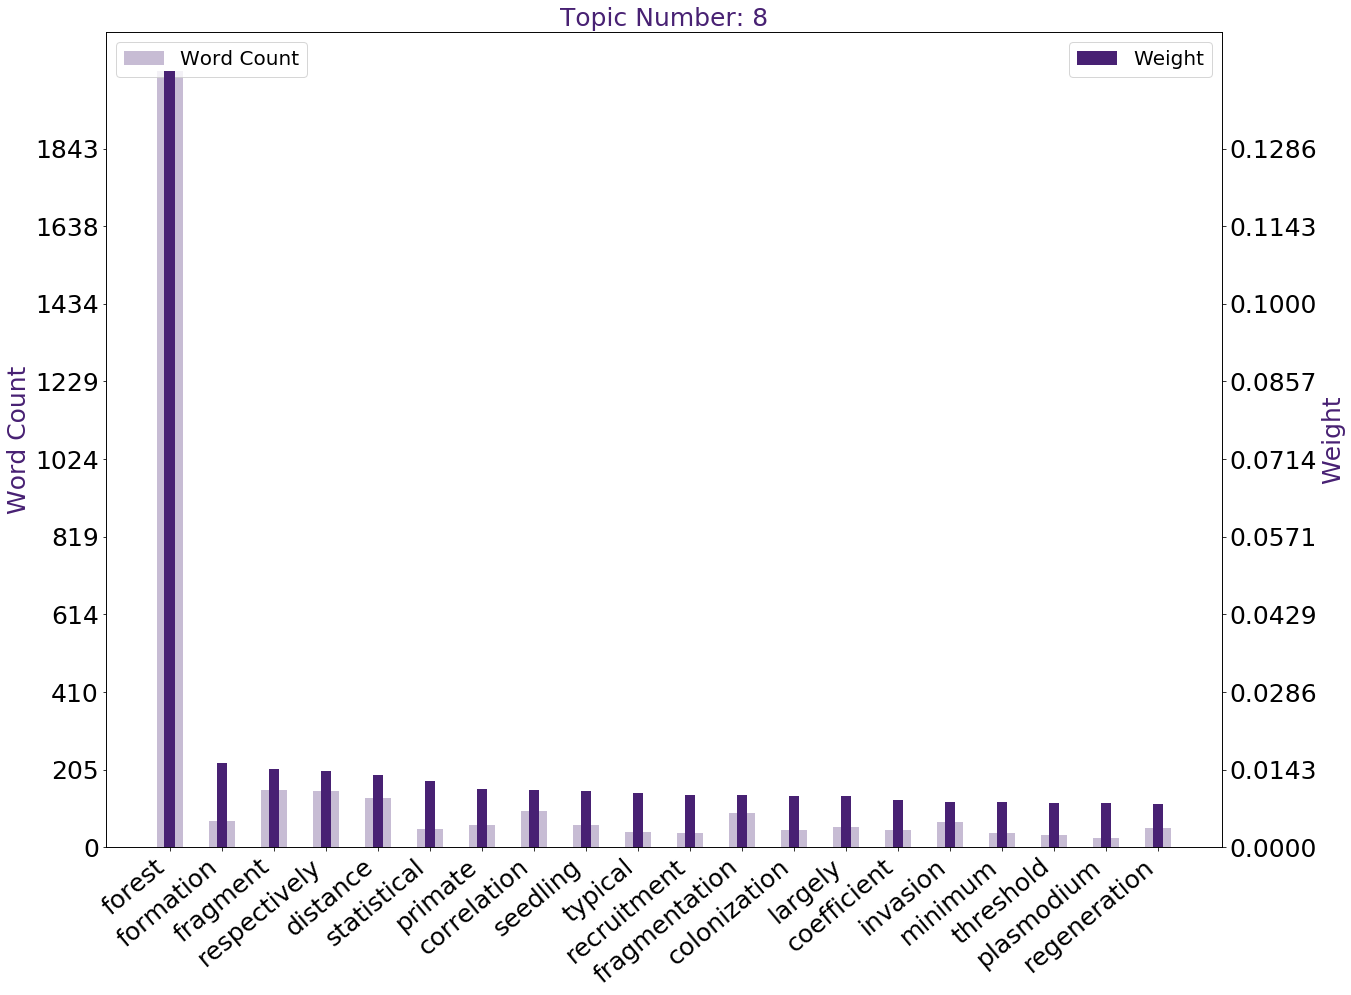

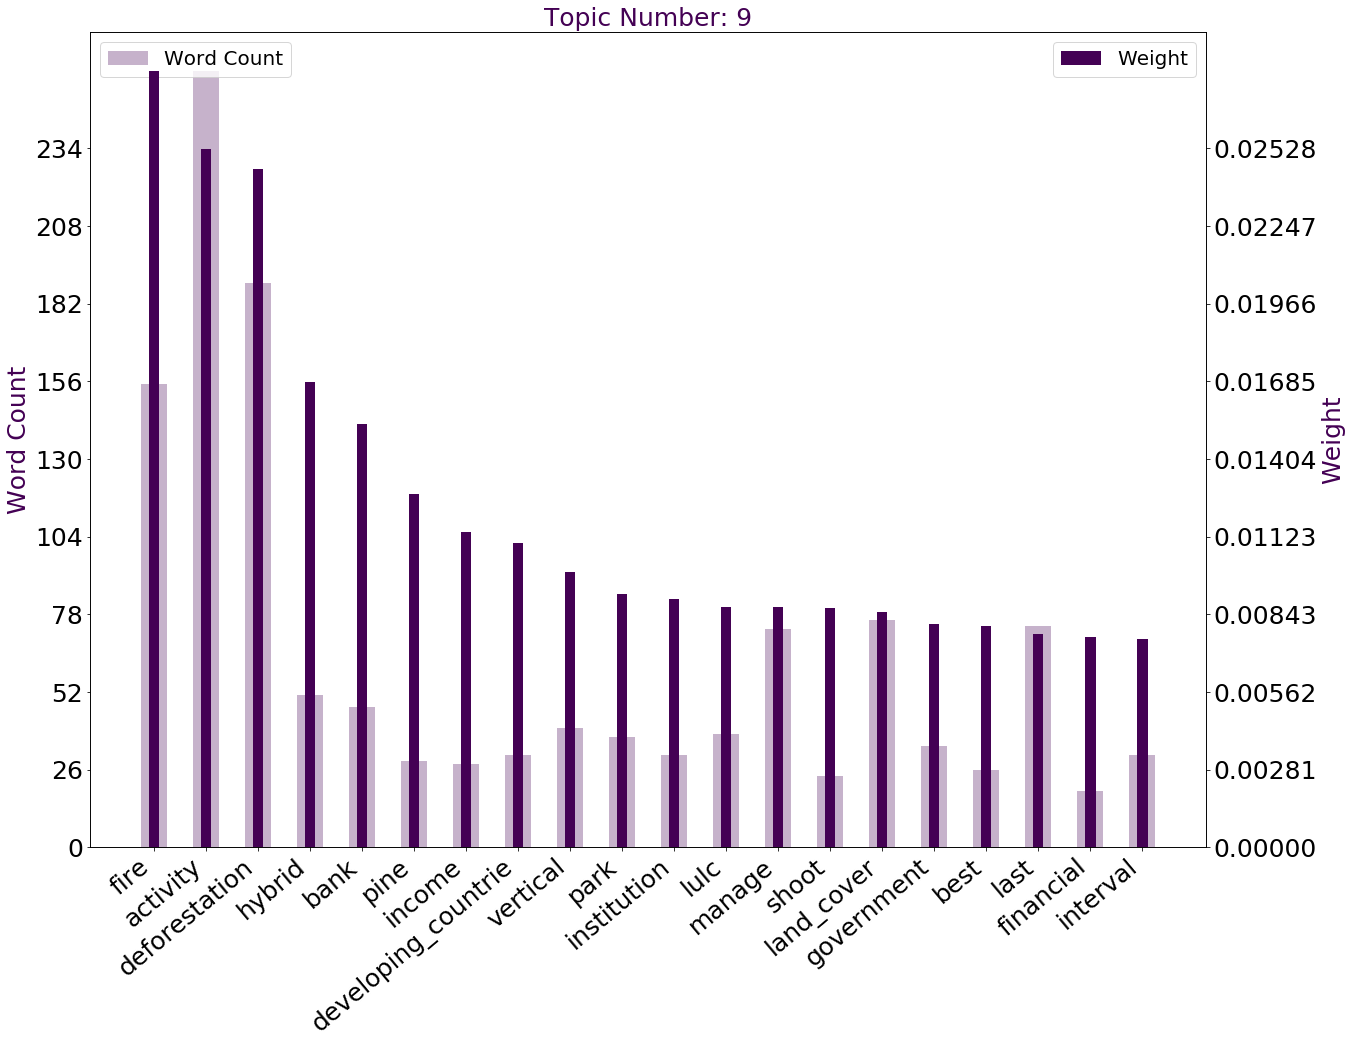

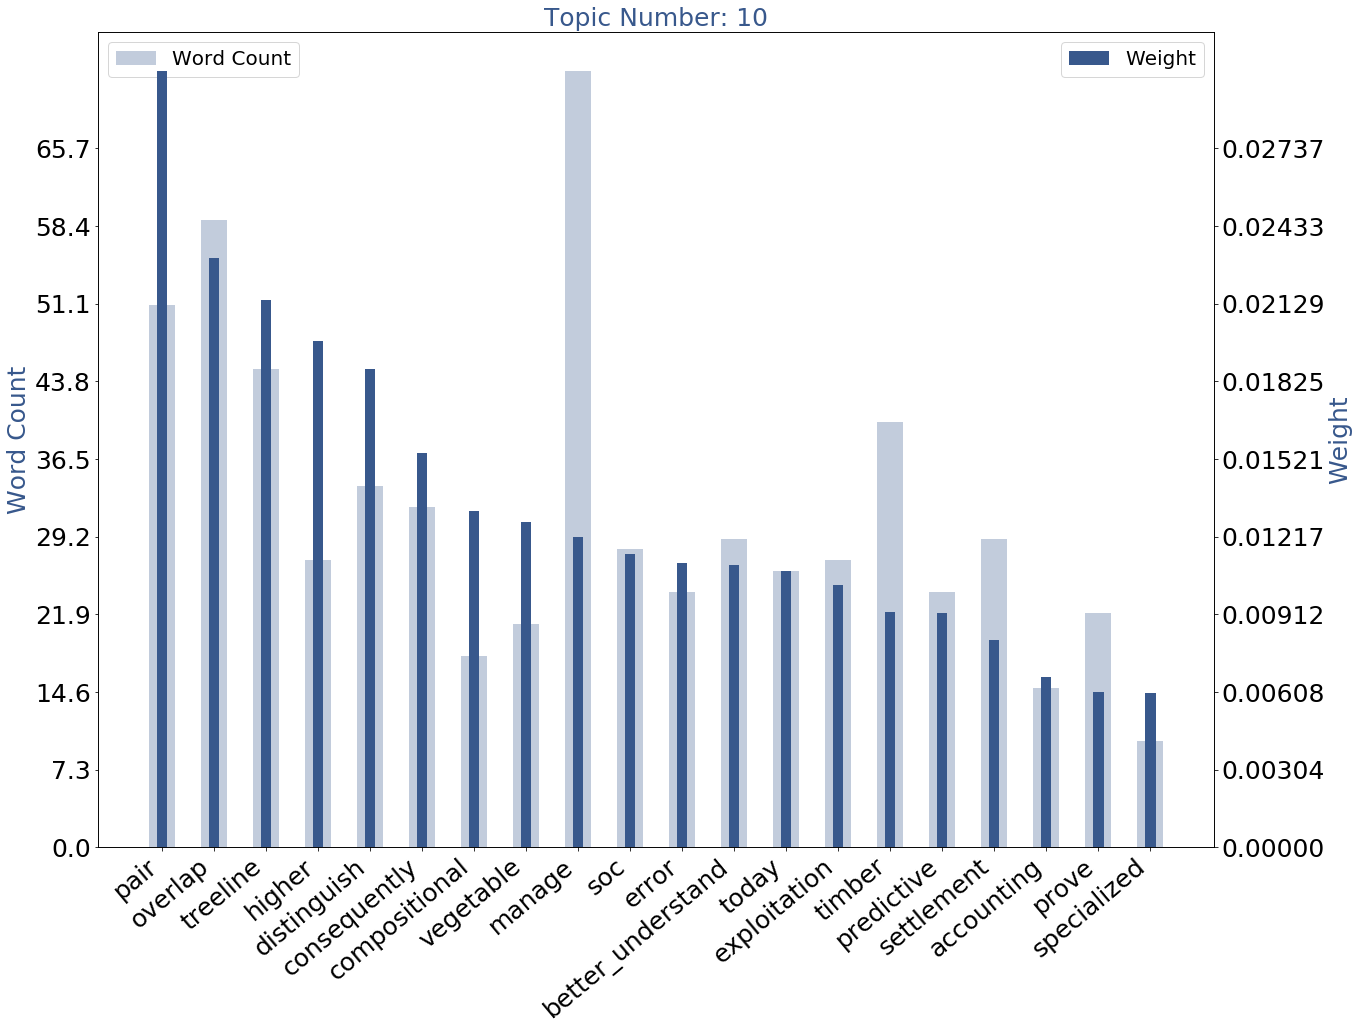

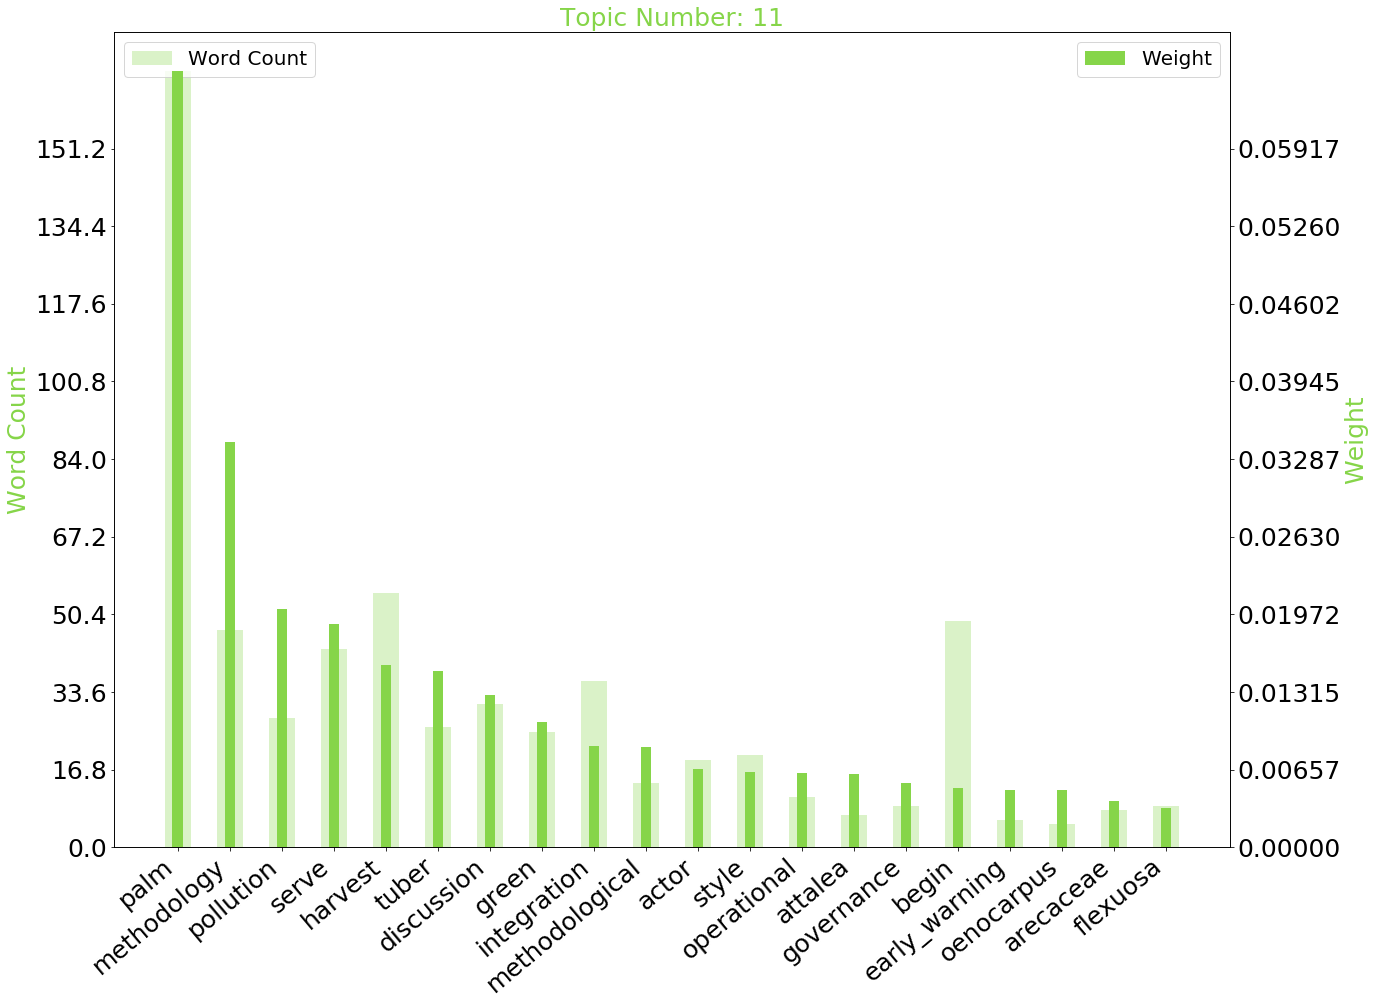

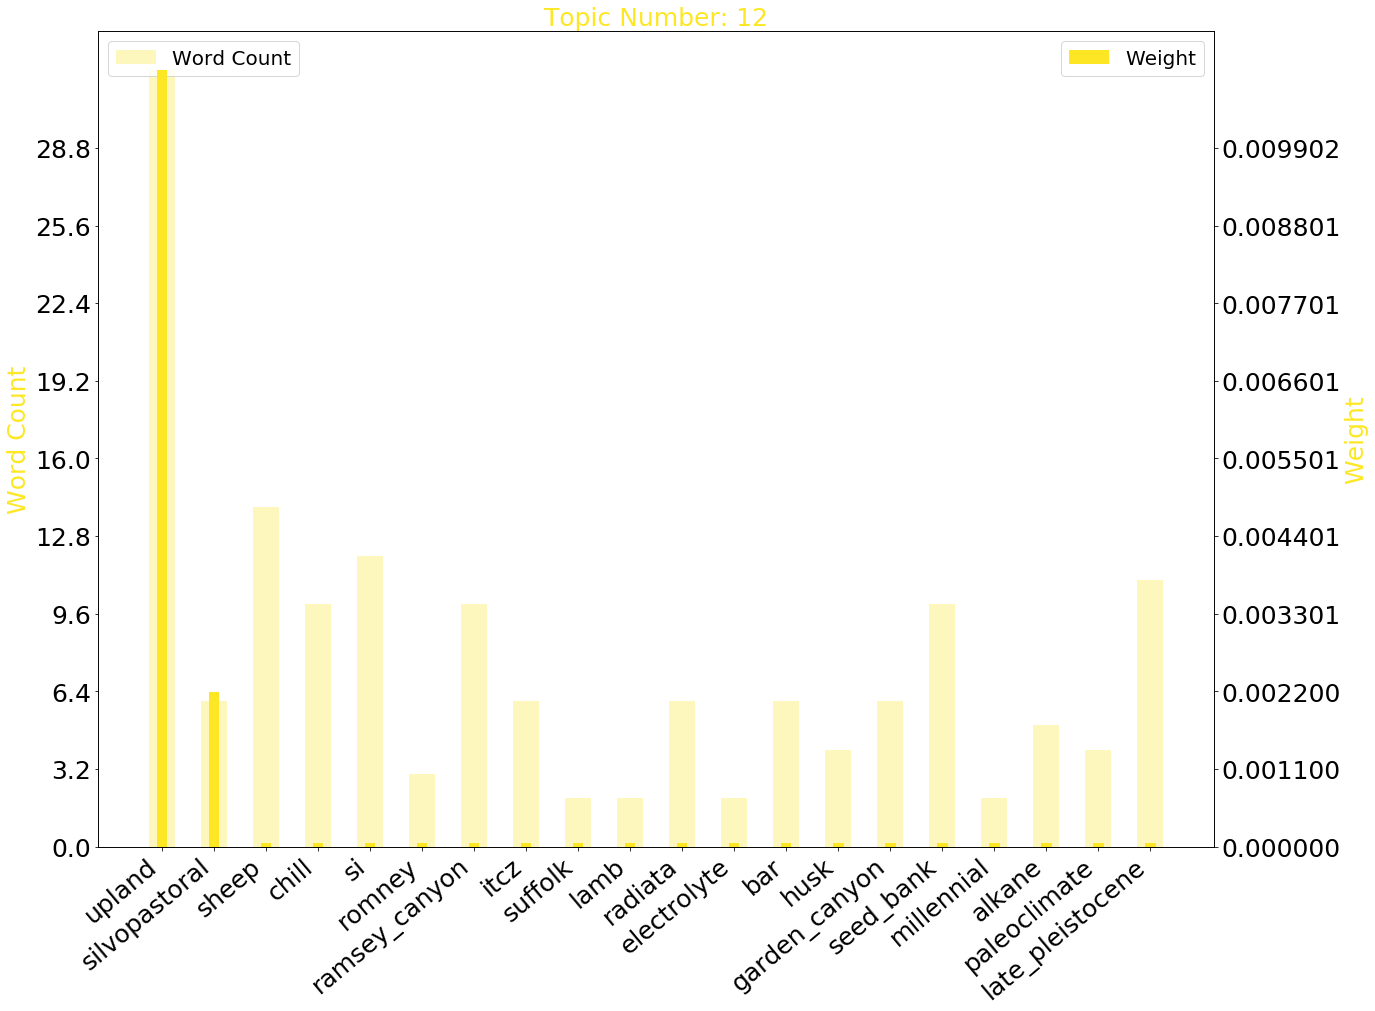

In [60]:
topic_builder(lda_model, session_folder_name,textual_data_lemmatized, topic_order)

In [60]:
word_count_list = [word_count for word_count in df.loc[df.topic_id==11, 'word_count']]

In [61]:
word_count_list

[32, 6, 14, 10, 12, 3, 10, 6, 2, 2, 6, 2, 6, 4, 6, 10, 2, 5, 4, 11]

In [62]:
word_count_increment = (max(word_count_list) - min(word_count_list))/10

In [63]:
y_axis_labels = np.arange(min(word_count_list), max(word_count_list), word_count_increment)

In [37]:
import dill
dill.dump_session('databases/testing.db')

In [39]:
rm testing.db